In [1]:
!pip install  nannyml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.5 MB 21.7 MB/s 
     |████████████████████████████████| 205 kB 62.8 MB/s 
     |████████████████████████████████| 11.2 MB 40.0 MB/s 
     |████████████████████████████████| 865 kB 45.7 MB/s 
     |████████████████████████████████| 72 kB 826 kB/s 
     |████████████████████████████████| 79.9 MB 105 kB/s 
     |████████████████████████████████| 15.2 MB 49.0 MB/s 
     |████████████████████████████████| 96 kB 2.2 MB/s 
     |████████████████████████████████| 2.0 MB 16.4 MB/s 
     |████████████████████████████████| 29.3 MB 61.2 MB/s 
     |████████████████████████████████| 237 kB 47.6 MB/s 
     |████████████████████████████████| 965 kB 51.0 MB/s 
     |████████████████████████████████| 51 kB 7.8 MB/s 
     |████████████████████████████████| 65 kB 4.5 MB/s 
     |████████████████████████████████| 9.1 MB 60.2 MB/s 
     |█████████████████████████████

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nannyml as nml
from scipy.spatial.transform import Rotation

# reference periods
# nalysis periods
# Days/week * Hours/day * events/hour
DPP = 7*24*24

np.random.seed(23)
s1 = np.random.randn(DPP*22)
x1 = s1 + np.random.randn(DPP*22)/8
x2 = s1 + np.random.randn(DPP*22)/8
x3 = np.random.randn(DPP*22)/8
xdat = np.array([x1, x2, x3]).T

rot = Rotation.from_euler('z', 90, degrees=True)

# following matrix multiplication implementation, we need a 3xN data matrix hence we transpose
ydat = np.matmul(rot.as_matrix(), xdat.T).T

# create overall array that has drifted and not drifted subsets.
# drift is sudden and affects last 5 weeks
dataar = np.concatenate(
    (xdat[:-5*DPP], ydat[-5*DPP:]),
    axis=0
)

# convert data to dataframe
datadf = pd.DataFrame(dataar, columns=['feature1', 'feature2', 'feature3'])

# add "timestamp" column
datadf = datadf.assign(ordered = pd.date_range(start='1/3/2020', freq='5min', periods=22*DPP))

# Adding helper column - duplicates date range functionality
datadf['week'] = datadf.ordered.dt.isocalendar().week - 1
# Adding partition column
datadf['partition'] = 'reference'

rf = datadf[datadf['partition'] == 'reference']
datadf.loc[datadf.week >= 8, ['partition']] = 'analysis'

rfa = datadf[datadf['partition'] == 'analysis']

# Assign random predictions and targets (we won't be using them but they are needed for NannyML)
datadf = datadf.assign(y_pred_proba = np.random.rand(DPP*22))
datadf = datadf.assign(y_true = np.random.randint(2, size=DPP*22))

Text(0.5, 0.98, 'Data Distributions before and after rotation drift')

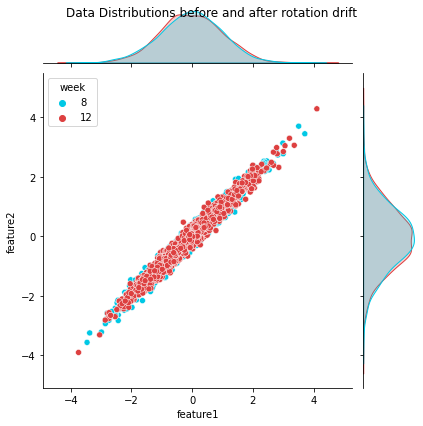

In [41]:
# let's construct a dataframe for visuzlization purposes
dat1 = datadf.loc[datadf.week == 8, ['feature1', 'feature2']][:1500]
dat1['week'] = 8
dat2 = datadf.loc[datadf.week == 12, ['feature1', 'feature2']][:1500]
dat2['week'] = 12
data_sample = pd.concat([dat1, dat2], ignore_index=True)

# let's plot
colors = nml.plots.colors.Colors
figure = sns.jointplot(
    data=data_sample,
    x="feature1",
    y="feature2",
    hue="week",
    palette=[colors.BLUE_SKY_CRAYOLA.value, colors.RED_IMPERIAL.value]
)
figure.fig.suptitle('Data Distributions before and after rotation drift')


In [42]:
# Let's first create the analysis and reference datasets NannyML needs.
reference = datadf.loc[datadf['partition'] == 'reference'].reset_index(drop=True)
reference.drop(['week', 'partition'], axis=1, inplace=True)
analysis = datadf.loc[datadf['partition'] == 'analysis'].reset_index(drop=True)
analysis.drop(['y_true', 'week', 'partition'], axis=1, inplace=True)
feature_column_names = ['feature1', 'feature2', 'feature3']
# Let's instantiate and calibrate univariate drift
univariate_calculator = nml.UnivariateStatisticalDriftCalculator(
    feature_column_names=feature_column_names,
    timestamp_column_name='ordered',
    chunk_size=DPP
)
univariate_calculator.fit(reference_data=reference)
# let's compute (and visualize) results across all the dataset.
univariate_results = univariate_calculator.calculate(data=analysis)
for feature in feature_column_names:
    figure = univariate_results.plot(
        kind='feature_distribution',
        feature_column_name=feature,
        plot_reference=True
    )
    figure.show()

/usr/local/lib/python3.7/dist-packages/nannyml/chunk.py:158: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.



Data Reconstruction with PCA

In [43]:
# Let's compute multivariate drift
rcerror_calculator = nml.DataReconstructionDriftCalculator(
    feature_column_names=feature_column_names,
    timestamp_column_name='ordered',
    chunk_size=DPP
).fit(reference_data=reference)
# let's compute results for analysis period
rcerror_results = rcerror_calculator.calculate(data=analysis)
# let's visualize results across all the dataset
figure = rcerror_results.plot(plot_reference=True)
figure.show()

/usr/local/lib/python3.7/dist-packages/nannyml/chunk.py:158: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.

/usr/local/lib/python3.7/dist-packages/nannyml/chunk.py:158: UserWarning:

The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.

